# Chapter 9. Speech Recognition A 
---------------------------------------------


In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import numpy.linalg
from ipywidgets import *
from IPython.display import display
from IPython.core.display import HTML
from notebook.nbextensions import enable_nbextension 


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()



### Comments

This chapter introduces some basic learning algorithms and then discussed the Viterbi algorithm.


## 9.1 Baysian Updates

Bayes' Rule enables to update beliefs as one makes observations.  

### Review of Bayes' Rule

Recall the basic setup.  The events $A_1, \ldots, A_N$ are a partition of the sample space $\Omega$ and $B$ is another event.  Then one has the following result.

**Bayes' Rule:**

$$P[A_n|B] = \frac{P(A_n)P[B|A_n]}{\sum_{m=1}^N P(A_m)P[B|A_m]}.$$

This rule extends to continuous random variables.  Say that $X$ takes values in $\{1, \ldots, N\}$
and that $P(X = n) = p_n$.  Assume also that the random variable $Y$ has pdf $f_n(y)$ when $X = n$.  That
is, formally, $f_{Y|X}[y|n] = f_n(y)$.  Then

$$P[X = n|y] = \frac{p_n f_n(y)}{\sum_{m=1}^N p_m f_m(y)}. $$



### Bias of Coin

As a first example, say that you have a coin that is fair with probability $p$ and biased with 
$P(H) = 0.6$ otherwise.  How do you update your estimate of $p$ as you flip the coin?

Say that you flip the coin once and get $H$.  Then, the probability that the coin is fair is

$$P[F | H] = \frac{P(F)P[H|F]}{P(F)P[H|F] + P[B)P[H|B]} = \frac{p.0.5}{p.0.5 + (1-p)0.6}. $$

Similalry,

$$P[F | T] = \frac{P(F)P[T|F]}{P(F)P[T|F] + P[B)P[T|B]} = \frac{p.0.5}{p.0.5 + (1-p)0.4}. $$


The formulas above enable us to update our estimate of $p$ after every coin flip.

Let's try this.  In the plot, $1$ represents $H$ and $0$ represents $T$.

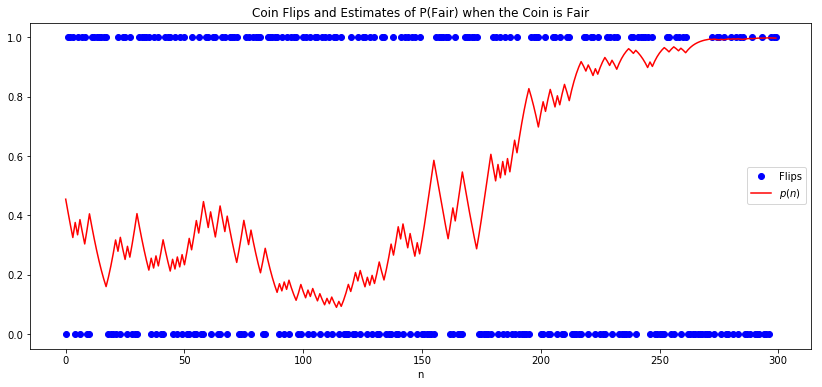

In [2]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def BU(w,N):  # Simulation of DTMC with initial state w given by button 
    a = np.arange(0,N)
    x = np.arange(0,N)
    p = np.arange(0.0,N)
    x[0] = 0
    p[0]=0.5*0.5/(0.5*0.5 + 0.6*0.5)
    if w == 'Fair': 
        q = 0.5
    else:
        q = 0.6
    for n in range(1,N):
        x[n] = np.random.binomial(1,q)
        if x[n] == 1:
            p[n] = 0.5*p[n-1]/(0.5*p[n-1] + 0.6*(1 - p[n-1]))
        else:
            p[n] = 0.5*p[n-1]/(0.5*p[n-1] + 0.4*(1 - p[n-1]))
    
    plt.figure(figsize = (14,6))
    plX, = plt.plot(a,x,'bo',label='Flips')
    plt.legend()
    plp, = plt.plot(a,p,'red',label='$p(n)$')
    plt.legend()
    plt.title('Coin Flips and Estimates of P(Fair) when the Coin is ' + w)
    plt.xlabel('n')   
        
u = widgets.ToggleButtons(options=['Fair', 'Biased'],
    description='Coin is ',
    disabled=False,
    button_style='info', 
    tooltip='Description',
) 

u2 = widgets.IntSlider(description='N', min = 50, max = 600, step = 10, value = 300, position = 'bottom')
        
z = widgets.interactive(BU, w = u, N = u2) 
display(z)
        

### Are these lightbulbs defective?

Assume you have a batch of lightbulbs that are all "good" and have an exponential lifetime with mean $1$ with probability $p$. Otherwise, they all have a lifetime that is exponentially distibuted with mean $0.9$ and are considered "defective". You observe the lifetimes of successive bulbs and update the probability that they are good.

Let $x$ be the lifetime of the next bulb. By Bayes' Rule:

$$P[G|x] = \frac{p \exp\{- x\}}{p \exp\{-x\} + (1 - p) (1/0.9) \exp\{ - x/0.9\}}.$$

Let us try this.  Note that we plot $10p(n)$ for legibility of the graph.

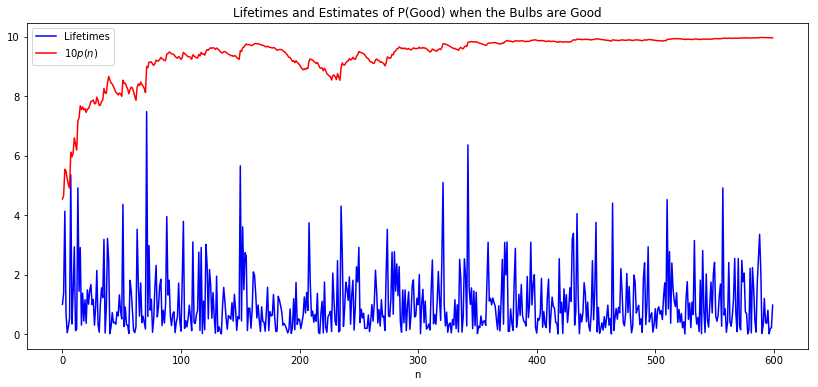

In [3]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def BU(w,N):  # Simulation of DTMC with initial state w given by button 
    a = np.arange(0,N)
    x = np.arange(0.0,N)
    p = np.arange(0.0,N)
    x[0] = 1
    p[0]=0.5*0.5/(0.5*0.5 + 0.6*0.5)
    if w == 'Good': 
        q = 1
    else:
        q = 0.9
    for n in range(1,N):
        x[n] = np.random.exponential(q)
        A = p[n-1]*math.exp(-x[n])
        p[n] = A/(A + (1 - p[n-1])*math.exp(-x[n]/0.9)/0.9)
    
    plt.figure(figsize = (14,6))
    plX, = plt.plot(a,x,'blue',label='Lifetimes')
    plt.legend()
    plp, = plt.plot(a,10*p,'red',label='$10p(n)$')
    plt.legend()
    plt.title('Lifetimes and Estimates of P(Good) when the Bulbs are ' + w)
    plt.xlabel('n')   
        
u = widgets.ToggleButtons(options=['Good', 'Defective'],
    description='Bulbs are ',
    disabled=False,
    button_style='info', 
    tooltip='Description',
) 

u2 = widgets.IntSlider(description='N', min = 50, max = 1000, step = 50, value = 600, position = 'bottom')
        
z = widgets.interactive(BU, w = u, N = u2) 
display(z)
        

### Which Markov Chain is This?

We observe the successive states of a Markov chain.  With probability $p$, the probability transition matrix is $P_1$ and the initial distribution is $\pi_1$. Otherwise, they are $P_2$ and $\pi_2$, respectively.  How do we update $p$ as we observe more transitions?

Again, we use Bayes' Rule.  Say that we observe $x_0$.  We have

$$ P[1|x_0] = \frac{p \pi_1(x_0)}{p \pi_1(x_0) + (1 - p) \pi_2(x_0)}.$$

Now assume we have observed $(x_0, \ldots, x_n)$ and have computed the probability $p_n = P[1|x_0, \ldots, x_n]$.  We then observe $x_{n+1}$.  Bayes' Rule implies that

$$p_{n+1} = \frac{p_n P_1(x_n, x_{n+1})}{p_n P_1(x_n, x_{n+1}) + (1-p_n)P_2(x_n, x_{n+1})}.$$

Let us try this when the state space is $\{0, 1\}$ and $\pi_1 = \pi_2 = [0.5, 0.5]$ and
$P_1(0, 1) = P_1(1, 0) = 0.2$ whereas $P_2(0,1) = 0.3$ and $P_2(1,0) = 0.1$.

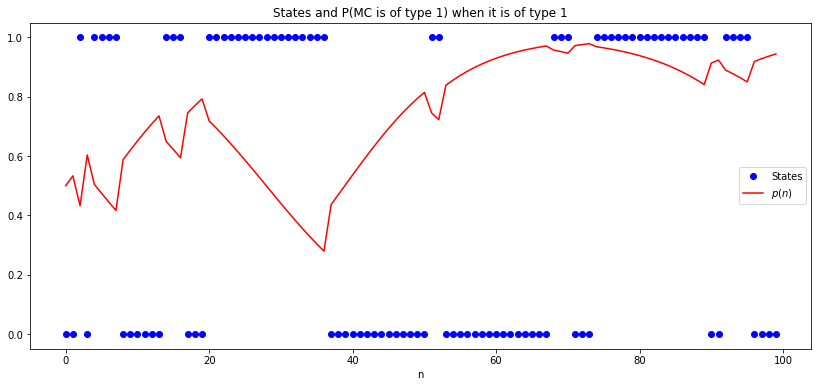

In [4]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def BUMC(w,N):  # Simulation of DTMC with initial state w given by button 
    a = np.arange(0,N)
    x = np.arange(0,N)
    p = np.arange(0.0,N)
    x[0] = 0
    p[0]=0.5
    if w == '1':
        c = 0
    else:
        c = 1
    P = np.zeros((2,2,2))
    P[0,:,:] = [[0.8,0.2],[0.2,0.8]]
    P[1,:,:] = [[0.7,0.3],[0.1,0.9]]
    for n in range(1,N):
        if x[n-1] == 0:
            x[n] = np.random.binomial(1,P[c,0,1])
        else:
            x[n] = 1 - np.random.binomial(1,P[c,1,0])
        p[n] = p[n-1]*P[0,x[n-1],x[n]]/(p[n-1]*P[0,x[n-1],x[n]] + (1 - p[n-1])*P[1,x[n-1],x[n]])
    
    plt.figure(figsize = (14,6))
    plX, = plt.plot(a,x,'bo',label='States')
    plt.legend()
    plp, = plt.plot(a,p,'red',label='$p(n)$')
    plt.legend()
    plt.title('States and P(MC is of type 1) when it is of type ' + w)
    plt.xlabel('n')   
        
u = widgets.ToggleButtons(options=['1', '2'],
    description='MC type',
    disabled=False,
    button_style='info', 
    tooltip='Description',
) 

u2 = widgets.IntSlider(description='N', min = 50, max = 300, step = 50, value = 100, position = 'bottom')
        
z = widgets.interactive(BUMC, w = u, N = u2) 
display(z)
        

## 9.2 Viterbi Algorithm

The Viterbi Algorithm calculates the most likely sequence $(x_0, x_1, \ldots, x_n)$ of states of a Markov chain give a sequence $(y_0, y_1, \ldots, y_n)$ of noisy measurements.  Here, the Markov chain $X_n$ has a known initial distribution $\pi$ and probability transition matrix $P$.  The observations are defined by $P[Y_n = y | X_0, \ldots X_n] = q(X_n,y)$ where $q$ is a known matrix.

From Bayes' Rule, we see that 

$$P[X_0 = x_0, \ldots, X_n = x_n | Y_0, \ldots, Y_n] = A \pi(x_0)q(x_0, Y_0) P(x_0, x_1) q(x_1, Y_1) \cdots P(x_{n-1}, x_n)q(x_n, Y_n)$$

where $A$ is a normalization constant that does not depend on $(x_0, \ldots, x_n)$.

Hence, the most likely sequence $(x_0, \ldots, x_n)$ given $(Y_0, \ldots, Y_n)$ is the sequence that maximizes the product $\pi(x_0)q(x_0, Y_0) P(x_0, x_1) q(x_1, Y_1) \cdots P(x_{n-1}, x_n)q(x_n, Y_n)$.  The logarithm of that product is equal to

$$ \log (\pi(x_0)q(x_0, Y_0)) + \sum_{m=1}^{n} \log(P(x_{m-1}, x_m)q(x_m, Y_m))  =  - d_0(\theta, x_0) - \sum_{m=1}^n d_m(x_{m-1}, x_m) $$

where $d_0(\theta, x_0) = - \log (\pi(x_0)q(x_0, Y_0))$ and $d_m(x_{m-1}, x_m) = - \log(P(x_{m-1}, x_m)q(x_m, Y_m))$.  Maximizing this expression is then equivalent to minimizing the sum $d_0(\theta, x_0) + \sum_{m=1}^n d_m(x_{m-1}, x_m)$  which can be viewed as the length of the path $(\theta, x_0, \ldots, x_n)$. That is, finding the most likely sequence of states is equivalent to finding a shortest path.  

We use the Bellman-Ford algorithm to find this shortest path.  Let $V_m(x_m)$ be the length of the shortest path $(x_m, x_{m+1}, \ldots, x_n)$, i.e., the smallest value of $d_{m+1}(x_m, x_{m+1}) + \cdots + d_n(x_{n-1},x_n)$.  By writing the length of the path $(x_{m-1}, x_m, \ldots, x_n)$ as $d_m(x_{m-1}, x_m)$ plus the length of the path $(x_m, \ldots, x_n)$, and minimizing first over the the path from $x_m$ and then over $x_m$, we find that

$$ V_{m-1}(x_{m-1}) = \min_{x_m} [ d_m (x_{m-1}, x_m) + V_m (x_m) ], m = 0, \ldots, n $$

where $x_{-1} := \theta$ and $V_n(x_n) := 0$.  We then solve recursively backwards, starting with $m = n$ and then continuing with $m = n-1, n-2, \ldots, 0$.

We illustrate the algorithm on the simplest possible example where $x_n \in \{0, 1\}$ and $y_n \in \{0, 1\}$. We assume $P(0, 1) = a, P(1, 0) = b$, $\pi(0) = b/(a + b)$.  Also, $q(x,y) = 1 - \epsilon$ if $x = y$ and $q(x, y) = \epsilon$ if $x \neq y$.  

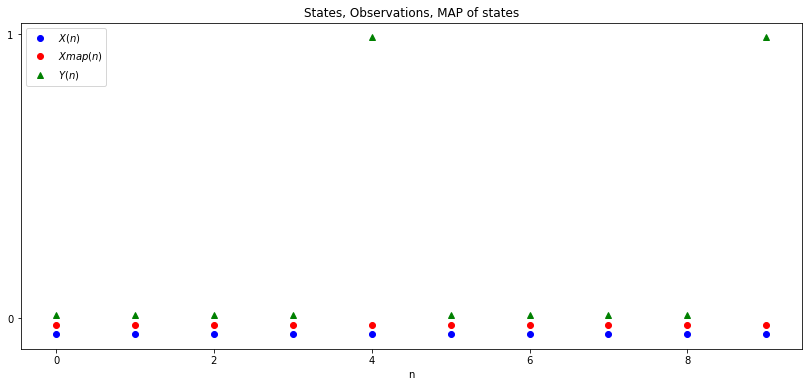

In [5]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def VIT(eps,a,b,N):  # Viterbi 
    t = np.arange(0,N)
    x = np.arange(0,N)
    xmap = np.arange(0,N)
    y = np.arange(0,N)
    V = np.zeros((N,2))
    d = np.zeros((N,2,2))  
    x[0] = np.random.binomial(1,b/(a+b))
    P = np.array([[1-a, a],[b, 1 -b]]) 
    sd = np.array([b/(a+b), a/(a+b)])
    Q = np.array([[1-eps, eps],[eps, 1-eps]])
    
    ## simulate MC and observations
    if x[0] == 0:
        y[0] = np.random.binomial(1,eps)
    else:
        y[0]= 1 - np.random.binomial(1,eps)
    for n in range(1,N):
        if x[n-1] == 0:
            x[n] = np.random.binomial(1,a)
        else:
            x[n] = 1 - np.random.binomial(1,b)
        if x[n] == 0:
            y[n] = np.random.binomial(1,eps)
        else:
            y[n]= 1 - np.random.binomial(1,eps)
    
    
    ##Belman-Ford Algorithm
    if y[0]== 0:
        c = np.array([1-eps, eps])
    else:
        c = np.array([eps,1 - eps])
    for n in range(1,N):
        for i in range(2):
            for j in range(2):
                d[n,i,j] = - math.log(P[i,j]) - math.log(Q[j,y[n]])
    for n in range(2,N):
        for i in range(2):
            V[N-n,i] = min(d[N-n,i,0]+ V[N-n+1,0],d[N-n,i,1]+ V[N-n+1,1])
    for i in range(2):
        V[0,i] = - math.log(c[i]) - math.log(sd[i]) + V[1,i]
    for n in range(0,N):
        xmap[n]= (V[n,1] < V[n,0])
    
    
    plt.figure(figsize = (14,6))
    plx, = plt.plot(t,x,'bo',label='$X(n)$')
    plt.legend()
    plxmap, = plt.plot(t,0.03 + 0.94*xmap,'ro',label='$Xmap(n)$')
    plt.legend()
    plY, = plt.plot(t,0.06+ 0.88*y,'g^',label='$Y(n)$')
    plt.legend()
    labels = ['0', '1']
    plt.yticks([0.05, 0.95], labels)
    plt.title('States, Observations, MAP of states')
    plt.xlabel('n')   
        
u1 = widgets.FloatSlider(description= '$\epsilon$', min = 0.05, max = 0.5, step = 0.05, value = 0.1)
u2 = widgets.FloatSlider(description= '$a$', min = 0.05, max = 0.5, step = 0.05, value = 0.1)
u3 = widgets.FloatSlider(description= '$b$', min = 0.05, max = 0.5, step = 0.05, value = 0.1)
u4 = widgets.IntSlider(description='N', min = 5, max = 20, step = 1, value = 10, position = 'bottom')
        
z = widgets.interactive(VIT, eps = u1, a = u2, b = u3, N = u4) 
display(z)
        

## 9.3 Clustering

Clustering is a basic process in learning.  

### Example 1: Student Scores, Same Variance

As a simple example, say that you look at the scores of students on a set of exams.  You want to classify the students into A = very good and B = not so good.  A simple rule would be "not-curved" where you decide that a student is A if her average score is larger than $80$ and is B otherwise.  The "curved" rule is more tricky because you have to choose the threshold based on the observed scores.  You may decide that $30\%$ of the students are $A$, in which case you adjust the threshold so that this happens.  A more subtle approach is to assume that the scores of $A$ students are ${\cal N}(a, \sigma^2)$ and those of $B$ students are ${\cal N}(b, \sigma^2)$, but we only know that $a > b$. In this case, here is an algorithm.  Let $X(1), \ldots, X(n)$ be the scores of the $N$ students.

* Initialize:  Let $z = (X(0) + \cdots + X(n))/(n+1)$;

* For $k = 0, 1, ...$: Define group $A$ to be students with score larger than $z(0)$, and group $B$ to be the other students.  Recompute the mean $a$ of group $A$ and the mean $b$ of group $B$.  Define $z(k+1) = (a + b)/2$.

We try this algorithm by first choosing $(a, b, \sigma)$ and we generate $M$ random scores that are ${\cal N}(a, \sigma^2)$ and $N$ that are ${\cal N}(b, \sigma^2)$.  We run the algorithm and look at the misclassified students.

Guessed a =  69.9684384958 ; Guessed b =  50.0612977279


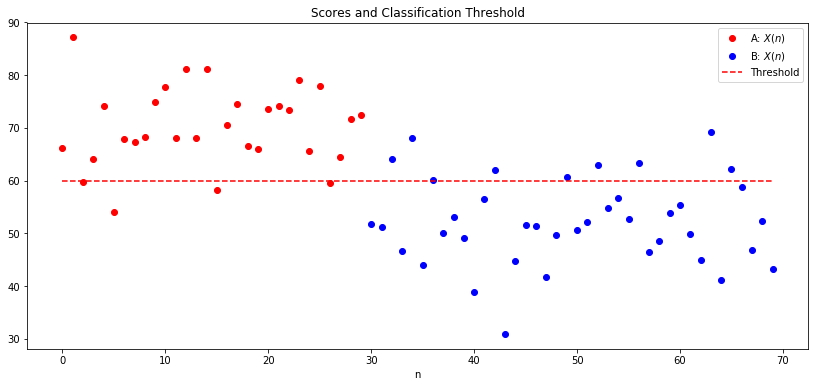

In [6]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def CLU(sig,a,b,M, N):  # Clustering 
    t = np.arange(0,M + N)
    x = np.arange(0.0,M + N)
    y = np.arange(0,M + N)
    ta = np.arange(0,M)
    xa = np.arange(0.0,M)
    tb = np.arange(0,N)
    xb = np.arange(0.0,N)
    S = 40
    
    ## Generate scores
    for n in range(M):
        x[n] = np.random.normal(a,sig)
        xa[n] = x[n]
    for n in range(N):
        x[n+M] = np.random.normal(b,sig)
        tb[n] = M + n
        xb[n] = x[n+M]
    z = sum(x)/(M+N)    
    for s in range(S):
        A = 0
        NA = 0
        B = 0
        NB = 0
        for n in range(N+M):
            if x[n] < z:
                NB = NB + 1
                B = B + x[n]
            else:
                NA = NA + 1
                A = A + x[n]
        z = (B/NB + A/NA)/2
    for n in range(M+N):
        y[n] = z
    print('Guessed a = ', A/NA,'; Guessed b = ', B/NB)
    
    plt.figure(figsize = (14,6))
    plx, = plt.plot(ta,xa,'ro',label='A: $X(n)$')
    plt.legend()
    plx, = plt.plot(tb,xb,'bo',label='B: $X(n)$')
    plt.legend()
    plxmap, = plt.plot(t,y,'r--',label='Threshold')
    plt.legend()
    plt.title('Scores and Classification Threshold')
    plt.xlabel('n')   
        
u1 = widgets.FloatSlider(description= '$\sigma$', min = 5, max = 30, step = 1, value = 8)
u2 = widgets.FloatSlider(description= '$a$', min = 60, max = 100, step = 10, value = 70)
u3 = widgets.FloatSlider(description= '$b$', min = 40, max = 60, step = 10, value = 50)
u4 = widgets.IntSlider(description='M', min = 20, max = 40, step = 5, value = 30, position = 'bottom')
u5 = widgets.IntSlider(description='N', min = 20, max = 60, step = 5, value = 40, position = 'bottom')
        
z = widgets.interactive(CLU, sig = u1, a = u2, b = u3, M = u4, N = u5) 
display(z)
        

### Example 2: Student Scores, Different Variances

The setup is the same, but we now assume that the cores of A-students are ${\cal N}(a, \sigma_a^2)$
and those of B-students are ${\cal N}(b, \sigma_b^2)$.  Here is our algorithm:

* Initialize: Let $z = (X(0) + \cdots + X(n))/(n+1)$.  Define group A to be students with a score larger than $z$. Let then $a$ be the mean of the scores of those students and $\sigma_a^2$ the sample variance of those scores, similarly for $b$ and $\sigma_b^2$.

* Steps $k = 0, 1, \ldots$:  $m$ is of group $A$ if $|X_m - a|/\sigma_a < |X_m - b|/\sigma_b$ and is of group $B$ otherwise.  Let $a$ = mean of group $A$, $\sigma_a^2$ = sample variance of group $B$, similarly for $b$ and $\sigma_b^2$.

Here is a simulation.  We choose the actual parameters $(a, b, \sigma_a, \sigma_b)$ and the number $M$ of students of group $A$ and $N$ of group $B$.  We run the algorithm and visualize the classification.

Guessed a =  69.0 ; Guessed sa =  7.0 ; Guessed b =  48.4 ; Gessed sb  6.4


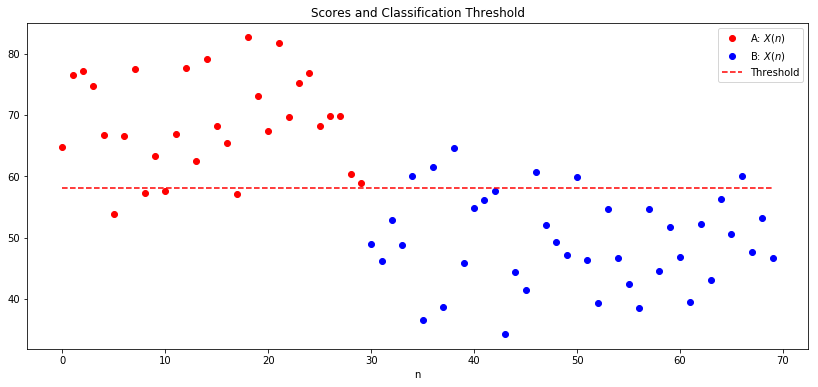

In [7]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def CLU2(siga,sigb,a,b,M, N):  # Clustering 
    t = np.arange(0,M + N)
    x = np.arange(0.0,M + N)
    y = np.arange(0,M + N)
    ta = np.arange(0,M)
    xa = np.arange(0.0,M)
    tb = np.arange(0,N)
    xb = np.arange(0.0,N)
    S = 40
    
    ## Generate scores
    for n in range(M):
        x[n] = np.random.normal(a,siga)
        xa[n] = x[n]
    for n in range(N):
        x[n+M] = np.random.normal(b,sigb)
        tb[n] = M + n
        xb[n] = x[n+M]
        
    z = sum(x)/(N+M)
    A = 0
    NA = 0
    SA = 0
    B = 0
    NB = 0
    SB = 0
    for n in range(N+M):  ## initialize
        if x[n] < z:
            NB = NB + 1
            B = B + x[n]
            SB = SB + x[n]**2
        else:
            NA = NA + 1
            A = A + x[n]
            SA = SA + x[n]**2
    ma = A/NA
    mb = B/NB
    sa = (SA/NA - ma**2)**0.5
    sb = (SB/NB - mb**2)**0.5
    z = (sb*ma + sa*mb)/(sa + sb)
        
    for s in range(S):  ## Classification
        A = 0
        NA = 0
        SA = 0
        B = 0
        NB = 0
        SB = 0        
        for n in range(N+M):
            if x[n] < z:
                NB = NB + 1
                B = B + x[n]
                SB = SB + x[n]**2
            else:
                NA = NA + 1
                A = A + x[n]
                SA = SA + x[n]**2
        ma = A/NA
        mb = B/NB
        sa = (SA/NA - ma**2)**0.5
        sb = (SB/NB - mb**2)**0.5
        z = (sb*ma + sa*mb)/(sa + sb)
    for n in range(M+N):
        y[n] = z
    ma = math.ceil(ma*10)/10
    sa = math.ceil(sa*10)/10
    mb = math.ceil(mb*10)/10
    sb = math.ceil(sb*10)/10
    print('Guessed a = ', ma,'; Guessed sa = ', sa, '; Guessed b = ', mb,'; Gessed sb ', sb)
    
    plt.figure(figsize = (14,6))
    plx, = plt.plot(ta,xa,'ro',label='A: $X(n)$')
    plt.legend()
    plx, = plt.plot(tb,xb,'bo',label='B: $X(n)$')
    plt.legend()
    plxmap, = plt.plot(t,y,'r--',label='Threshold')
    plt.legend()
    plt.title('Scores and Classification Threshold')
    plt.xlabel('n')   
        
ua = widgets.FloatSlider(description= '$\sigma_a$', min = 5, max = 30, step = 1, value = 8)
ub = widgets.FloatSlider(description= '$\sigma_b$', min = 5, max = 30, step = 1, value = 8)
u2 = widgets.FloatSlider(description= '$a$', min = 60, max = 100, step = 10, value = 70)
u3 = widgets.FloatSlider(description= '$b$', min = 40, max = 60, step = 10, value = 50)
u4 = widgets.IntSlider(description='M', min = 20, max = 40, step = 5, value = 30, position = 'bottom')
u5 = widgets.IntSlider(description='N', min = 20, max = 60, step = 5, value = 40, position = 'bottom')
        
z = widgets.interactive(CLU2, siga = ua, sigb = ub, a = u2, b = u3, M = u4, N = u5) 
display(z)
        

### Example 3: 2D Classification

In this example, we generate $M$ pairs $(X, Y)$ that are distributed like $(a_1, a_2)' + A(v_1, v_2)'$ where $A$ is a $2$-by-$2$ matrix and $v_1, v_2$ are independent ${\cal N}(0, 1)$.  We also generate $N$ pairs that are distributed like $(b_1, b_2)' + B(v_1, v_2)'$.  We then classify the $M + N$ points.   Here is the classification algorithm:

* Initialize: Let $\{c + dx, x \in \Re\}$ be the linear regression of $Y$ over $R$. 

* Subsequent steps:  The points $A$ are above the line $\{c + dx, x \in \Re\}$ and the points $B$ are the other points. Let $a$ and $b$ be the mean values of group $A$ and $B$, respectively.  Let then $\{c + dx, x \in \Re\}$ be the bisectrice of the segment $(a, b)$.  

Here is a simulation. To simplify the user input, we choose $(b_1, b_2) = (0, 0)$ and $(a_1, a_2) = (a, a)$.  Also, we specify that $B$ is the indentity matrix multipled by $\sigma_b$.  Finally, $A = \sigma_a \times [[1, 0.5], [0.5, 1]]$. 

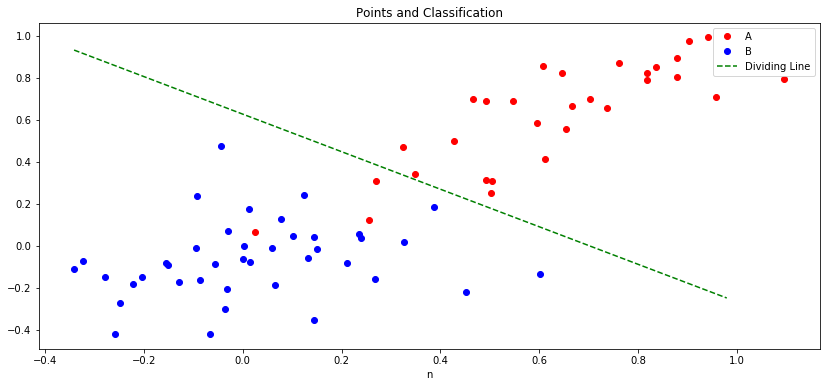

In [8]:
## %matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats


def CLU3(siga,sigb,a,M, N):  # Clustering 
    t = np.arange(0,M + N)
    x = np.zeros((2,M + N))
    S = 40
    D = np.array([[1, 0.5],[0.5,1]])
    
    ## Generate points
    for n in range(N):
        x[:,n] = np.random.normal(0,sigb,2)
    for n in range(M):
        x[:,n+N] = np.dot(D,np.random.normal(a,siga,2))
    sx2 = 0
    sxy = 0
    m = sum(x)/(N+M)
    for n in range(N+M):  ## initialize
        sx2 = sx2 + x[0,n]**2
        sxy = sxy + x[0,n]*x[1,n]
    sx2 = sx2/(N+M) - m[0]**2
    sxy = sxy/(N+M) - m[0]*m[1]
    d = sxy/sx2
    c = m[1] - d*m[0]       
        
    for s in range(S):  ## Classification
        A = np.array([0,0])
        NA = 0
        B = np.array([0,0])
        NB = 0        
        for n in range(N+M):
            if x[1,n] < c + d*x[0,n]:
                NB = NB + 1
                B = B + x[:,n]
            else:
                NA = NA + 1
                A = A + x[:,n]
        ma = A/NA
        mb = B/NB
        d = (mb[0] - ma[0])/(ma[1] - mb[1])
        c = (ma[1] + mb[1] - d*(ma[0] + mb[0]))/2
        
    y = np.zeros((2,100))
    minx = min(x[0,:])
    maxx = max(x[1,:])
    delta = (maxx - minx)/100
    for n in range(100):
        y[0,n] = minx + delta*n 
        y[1,n] = c + d*y[0,n]
    
    plt.figure(figsize = (14,6))
    plxb, = plt.plot(x[0,N:M+N], x[1,N:M+N],'ro',label='A')
    plt.legend()
    plxa, = plt.plot(x[0,0:N], x[1,0:N],'bo',label='B')
    plt.legend()   
    ply, = plt.plot(y[0,:],y[1,:],'g--',label='Dividing Line')
    plt.legend()
    plt.title('Points and Classification')
    plt.xlabel('n')   
        
ua = widgets.FloatSlider(description= '$\sigma_a$', min = 0.1, max = 1, step = 0.1, value = 0.2)
ub = widgets.FloatSlider(description= '$\sigma_b$', min = 0.1, max = 1, step = 0.1, value = 0.2)
u3 = widgets.FloatSlider(description= '$a$', min = 0.05, max = 1, step = 0.05, value = 0.4)
u4 = widgets.IntSlider(description='M', min = 20, max = 40, step = 5, value = 30, position = 'bottom')
u5 = widgets.IntSlider(description='N', min = 20, max = 60, step = 5, value = 40, position = 'bottom')
        
z = widgets.interactive(CLU3, siga = ua, sigb = ub, a = u3, M = u4, N = u5) 
display(z)
        